In [1]:
# List all device
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Lambda, GRU, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.activations import softmax
from keras.optimizers import SGD, RMSprop
import math
import pickle
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [5]:
def calculate_class(returns):
    """Find the class for each LSTM sequence based on the median returns."""
    median_returns = returns.median(axis=1)
    labels = returns.iloc[:, :].apply(lambda x: np.where
                                      (x >= median_returns, 1, 0), axis=0)
    return labels

In [6]:
np.random.seed(2)
x_train = np.random.rand(10,2)
x_train.shape

(10, 2)

In [7]:
y_train = to_categorical(calculate_class(pd.DataFrame(x_train)).values, 2)
y_train.shape

(10, 2, 2)

In [8]:
x_train[0]

array([0.4359949 , 0.02592623])

In [9]:
y_train[0]

array([[0., 1.],
       [1., 0.]], dtype=float32)

In [10]:
timestep = 1

In [11]:
x_series = [x_train[i:i+timestep, :] for i in range(1, x_train.shape[0] - timestep)]
y_series = [y_train[i+timestep] for i in range(y_train.shape[0] - timestep - 1)]
x = np.array(x_series)
y = np.array(y_series)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (8, 1, 2)
y shape: (8, 2, 2)


In [12]:
x_train1 = x_train[:-1]
x_train1

array([[0.4359949 , 0.02592623],
       [0.54966248, 0.43532239],
       [0.4203678 , 0.33033482],
       [0.20464863, 0.61927097],
       [0.29965467, 0.26682728],
       [0.62113383, 0.52914209],
       [0.13457995, 0.51357812],
       [0.18443987, 0.78533515],
       [0.85397529, 0.49423684]])

In [13]:
x_train

array([[0.4359949 , 0.02592623],
       [0.54966248, 0.43532239],
       [0.4203678 , 0.33033482],
       [0.20464863, 0.61927097],
       [0.29965467, 0.26682728],
       [0.62113383, 0.52914209],
       [0.13457995, 0.51357812],
       [0.18443987, 0.78533515],
       [0.85397529, 0.49423684],
       [0.84656149, 0.07964548]])

In [14]:
y_train1 = y_train[1:]

In [15]:
train_gen = TimeseriesGenerator(x_train1, y_train1,
                                length=timestep, sampling_rate=1,
                                batch_size=2)

In [16]:
for i in range(train_gen[0][0].shape[0]):
    print(train_gen[0][0][i], train_gen[0][1][i])

[[0.4359949  0.02592623]] [[0. 1.]
 [1. 0.]]
[[0.54966248 0.43532239]] [[1. 0.]
 [0. 1.]]


In [17]:
train_gen[0][1].shape

(2, 2, 2)

In [18]:
regressor = Sequential()
regressor.add(LSTM(units=10, input_shape=(timestep, 2)))
# regressor.add(LSTM(units=10, input_shape=(timestep, 2)))
regressor.add(Dense(4, activation='relu'))
regressor.add(Reshape((2, 2)))
regressor.add(Lambda(lambda x: softmax(x, axis=-1)))
# regressor.add(Dense(2, activation='softmax'))
regressor.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2, 2)              0         
Total params: 564
Trainable params: 564
Non-trainable params: 0
_________________________________________________________________


In [19]:
# result = regressor.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=1000)
result = regressor.fit(x, y, steps_per_epoch=len(train_gen), epochs=1000)

Epoch 1/1000
4/4 [==============================] - 1s 280ms/step - loss: 0.6921 - acc: 0.4766
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6915 - acc: 0.5078
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6905 - acc: 0.6250
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6875 - acc: 0.7500
Epoch 5/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6861 - acc: 0.7500
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6853 - acc: 0.7500
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6844 - acc: 0.7500
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6836 - acc: 0.7344
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6827 - acc: 0.6719
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.6819 - acc: 0.6406
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - 

4/4 [==============================] - 0s 5ms/step - loss: 0.5418 - acc: 0.7500
Epoch 89/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5392 - acc: 0.7500
Epoch 90/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5367 - acc: 0.7500
Epoch 91/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5341 - acc: 0.7812
Epoch 92/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5315 - acc: 0.8125
Epoch 93/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5288 - acc: 0.8125
Epoch 94/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5262 - acc: 0.8125
Epoch 95/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5235 - acc: 0.8125
Epoch 96/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.5208 - acc: 0.8125
Epoch 97/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.5180 - acc: 0.8125
Epoch 98/1000
4/4 [==============================] - 0s 5ms/step - loss: 0

4/4 [==============================] - 0s 5ms/step - loss: 0.2972 - acc: 0.8438
Epoch 175/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2946 - acc: 0.8516
Epoch 176/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2921 - acc: 0.8516
Epoch 177/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2896 - acc: 0.8594
Epoch 178/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2872 - acc: 0.8516
Epoch 179/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2848 - acc: 0.8594
Epoch 180/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2824 - acc: 0.8594
Epoch 181/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2800 - acc: 0.8594
Epoch 182/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.2777 - acc: 0.8672
Epoch 183/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2754 - acc: 0.8594
Epoch 184/1000
4/4 [==============================] - 0s 8m

4/4 [==============================] - 0s 5ms/step - loss: 0.1614 - acc: 0.8984
Epoch 261/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1607 - acc: 0.8984
Epoch 262/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1600 - acc: 0.8984
Epoch 263/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1593 - acc: 0.8984
Epoch 264/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.1586 - acc: 0.8984
Epoch 265/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.1580 - acc: 0.8984
Epoch 266/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1574 - acc: 0.9062
Epoch 267/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1568 - acc: 0.8984
Epoch 268/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1561 - acc: 0.8984
Epoch 269/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1555 - acc: 0.8984
Epoch 270/1000
4/4 [==============================] - 0s 6ms/st

4/4 [==============================] - 0s 4ms/step - loss: 0.1340 - acc: 0.9062
Epoch 347/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1339 - acc: 0.9062
Epoch 348/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1339 - acc: 0.9062
Epoch 349/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1338 - acc: 0.9062
Epoch 350/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1336 - acc: 0.9062
Epoch 351/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1336 - acc: 0.8984
Epoch 352/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1335 - acc: 0.9062
Epoch 353/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1334 - acc: 0.9062
Epoch 354/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1334 - acc: 0.9062
Epoch 355/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1333 - acc: 0.9062
Epoch 356/1000
4/4 [==============================] - 0s 6ms/step

4/4 [==============================] - 0s 6ms/step - loss: 0.1308 - acc: 0.9062
Epoch 433/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 434/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 435/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1307 - acc: 0.9062
Epoch 436/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 437/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 438/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1307 - acc: 0.8984
Epoch 439/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 440/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 441/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1307 - acc: 0.9062
Epoch 442/1000
4/4 [==============================] - 0s 7ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 519/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.1302 - acc: 0.9062
Epoch 520/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.1302 - acc: 0.9062
Epoch 521/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 522/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 523/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1302 - acc: 0.9062
Epoch 524/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1302 - acc: 0.9062
Epoch 525/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1302 - acc: 0.9062
Epoch 526/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1302 - acc: 0.9062
Epoch 527/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.1302 - acc: 0.9062
Epoch 528/1000
4/4 [==============================] - 0s 3ms/step

4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.9062
Epoch 605/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1301 - acc: 0.9062
Epoch 606/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.9062
Epoch 607/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.9062
Epoch 608/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.8984
Epoch 609/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.9062
Epoch 610/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.9062
Epoch 611/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1301 - acc: 0.9062
Epoch 612/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.1301 - acc: 0.9062
Epoch 613/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.9062
Epoch 614/1000
4/4 [==============================] - 0s 4ms/step

4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 691/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 692/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 693/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1301 - acc: 0.8984
Epoch 694/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 695/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1300 - acc: 0.9062
Epoch 696/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 697/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 698/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 699/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 700/1000
4/4 [==============================] - 0s 7ms/step

4/4 [==============================] - 0s 8ms/step - loss: 0.1300 - acc: 0.9062
Epoch 777/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1300 - acc: 0.9062
Epoch 778/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 779/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 780/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 781/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 782/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 783/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 784/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 785/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 786/1000
4/4 [==============================] - 0s 7ms/step

4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 863/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 864/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1300 - acc: 0.9062
Epoch 865/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 866/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 867/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 868/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 869/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.8984
Epoch 870/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 871/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 872/1000
4/4 [==============================] - 0s 6ms/step

4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 949/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 950/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 951/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 952/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 953/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 954/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1300 - acc: 0.9062
Epoch 955/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 956/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1300 - acc: 0.9062
Epoch 957/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1300 - acc: 0.9062
Epoch 958/1000
4/4 [==============================] - 0s 7ms/step

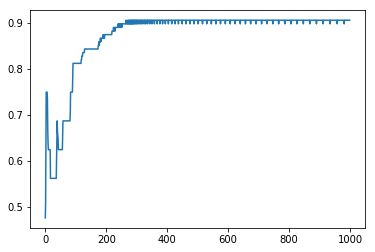

In [20]:
plt.plot(result.history["acc"])

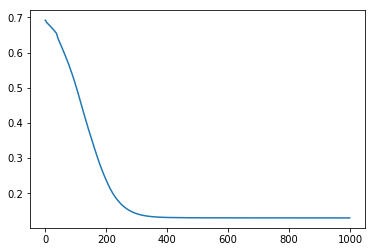

In [21]:
plt.plot(result.history["loss"])

In [22]:
# regressor.predict_generator(train_gen)
regressor.predict(x)

array([[[1.38582230e-08, 1.00000000e+00],
        [9.99974728e-01, 2.52676018e-05]],

       [[6.20859737e-08, 9.99999881e-01],
        [9.99944806e-01, 5.51881785e-05]],

       [[9.99998450e-01, 1.50818926e-06],
        [5.00000000e-01, 5.00000000e-01]],

       [[7.89431169e-07, 9.99999166e-01],
        [9.99776781e-01, 2.23204930e-04]],

       [[1.14659935e-08, 1.00000000e+00],
        [9.99976039e-01, 2.39197216e-05]],

       [[9.99997854e-01, 2.10029407e-06],
        [5.00000000e-01, 5.00000000e-01]],

       [[1.00000000e+00, 1.73707377e-08],
        [5.00000000e-01, 5.00000000e-01]],

       [[2.88162966e-10, 1.00000000e+00],
        [9.99997377e-01, 2.67043310e-06]]], dtype=float32)

In [23]:
y_train[1:]

array([[[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]]], dtype=float32)

In [24]:
x_train.shape

(10, 2)

In [25]:
y_train.shape

(10, 2, 2)

In [26]:
x.shape

(8, 1, 2)

In [27]:
x

array([[[0.54966248, 0.43532239]],

       [[0.4203678 , 0.33033482]],

       [[0.20464863, 0.61927097]],

       [[0.29965467, 0.26682728]],

       [[0.62113383, 0.52914209]],

       [[0.13457995, 0.51357812]],

       [[0.18443987, 0.78533515]],

       [[0.85397529, 0.49423684]]])

In [28]:
y

array([[[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.]]], dtype=float32)

In [29]:
regressor2 = Sequential()
regressor2.add(Dense(10, input_shape=(1, 2)))
regressor2.add(Dense(4, activation='relu'))
regressor2.add(Reshape((2, 2)))
regressor2.add(Lambda(lambda x: softmax(x, axis=-1)))
regressor2.add(Dense(2, activation='softmax'))
regressor2.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 10)             30        
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              44        
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2)              0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 2, 2)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2, 2)              6         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [30]:
# regressor2.predict_generator(train_gen)
regressor2.fit(x, y, epochs=2000, batch_size=2)
# regressor2.fit(x_train, y_train, epochs=100, batch_size=2)

Epoch 1/2000
8/8 [==============================] - 1s 81ms/step - loss: 0.7472 - acc: 0.5000
Epoch 2/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.7420 - acc: 0.5000
Epoch 3/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.7386 - acc: 0.5000
Epoch 4/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.7357 - acc: 0.5000
Epoch 5/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.7330 - acc: 0.5000
Epoch 6/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.7307 - acc: 0.5000
Epoch 7/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.7284 - acc: 0.5000
Epoch 8/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.7262 - acc: 0.5000
Epoch 9/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.7239 - acc: 0.5000
Epoch 10/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.7219 - acc: 0.5000
Epoch 11/2000
8/8 [==============================] - 0s 2ms/step - l

8/8 [==============================] - 0s 1ms/step - loss: 0.6635 - acc: 0.6250
Epoch 89/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.6630 - acc: 0.6250
Epoch 90/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6628 - acc: 0.6250
Epoch 91/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6621 - acc: 0.6250
Epoch 92/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6616 - acc: 0.6250
Epoch 93/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6611 - acc: 0.6250
Epoch 94/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6607 - acc: 0.6250
Epoch 95/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6601 - acc: 0.6250
Epoch 96/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6596 - acc: 0.6250
Epoch 97/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6590 - acc: 0.6250
Epoch 98/2000
8/8 [==============================] - 0s 1ms/step - loss: 0

8/8 [==============================] - 0s 1ms/step - loss: 0.6100 - acc: 0.8125
Epoch 175/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6091 - acc: 0.8125
Epoch 176/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6082 - acc: 0.8125
Epoch 177/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6069 - acc: 0.8125
Epoch 178/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.6061 - acc: 0.8125
Epoch 179/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6056 - acc: 0.8125
Epoch 180/2000
8/8 [==============================] - 0s 981us/step - loss: 0.6043 - acc: 0.8125
Epoch 181/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6037 - acc: 0.8125
Epoch 182/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6026 - acc: 0.8125
Epoch 183/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.6024 - acc: 0.8125
Epoch 184/2000
8/8 [==============================] - 0s 942us/

8/8 [==============================] - 0s 992us/step - loss: 0.5424 - acc: 0.8125
Epoch 261/2000
8/8 [==============================] - 0s 981us/step - loss: 0.5416 - acc: 0.8125
Epoch 262/2000
8/8 [==============================] - 0s 914us/step - loss: 0.5414 - acc: 0.8125
Epoch 263/2000
8/8 [==============================] - 0s 936us/step - loss: 0.5404 - acc: 0.8125
Epoch 264/2000
8/8 [==============================] - 0s 985us/step - loss: 0.5396 - acc: 0.8125
Epoch 265/2000
8/8 [==============================] - 0s 873us/step - loss: 0.5392 - acc: 0.8125
Epoch 266/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.5384 - acc: 0.8125
Epoch 267/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.5377 - acc: 0.8125
Epoch 268/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.5370 - acc: 0.8125
Epoch 269/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.5363 - acc: 0.8125
Epoch 270/2000
8/8 [==============================] -

8/8 [==============================] - 0s 987us/step - loss: 0.4943 - acc: 0.8125
Epoch 347/2000
8/8 [==============================] - 0s 842us/step - loss: 0.4946 - acc: 0.8125
Epoch 348/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4940 - acc: 0.8125
Epoch 349/2000
8/8 [==============================] - 0s 980us/step - loss: 0.4929 - acc: 0.8125
Epoch 350/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4934 - acc: 0.8125
Epoch 351/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4928 - acc: 0.8125
Epoch 352/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4923 - acc: 0.8125
Epoch 353/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4917 - acc: 0.8125
Epoch 354/2000
8/8 [==============================] - 0s 896us/step - loss: 0.4913 - acc: 0.8125
Epoch 355/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4907 - acc: 0.8125
Epoch 356/2000
8/8 [==============================] - 0s 

8/8 [==============================] - 0s 1ms/step - loss: 0.4663 - acc: 0.8125
Epoch 433/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4664 - acc: 0.8125
Epoch 434/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4658 - acc: 0.8125
Epoch 435/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4656 - acc: 0.8125
Epoch 436/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4656 - acc: 0.8125
Epoch 437/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4651 - acc: 0.8125
Epoch 438/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4649 - acc: 0.8125
Epoch 439/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4652 - acc: 0.8125
Epoch 440/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4643 - acc: 0.8125
Epoch 441/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.4641 - acc: 0.8125
Epoch 442/2000
8/8 [==============================] - 0s 1ms/step

8/8 [==============================] - 0s 1ms/step - loss: 0.3347 - acc: 0.8125
Epoch 519/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3337 - acc: 0.8125
Epoch 520/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3331 - acc: 0.8125
Epoch 521/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3319 - acc: 0.8125
Epoch 522/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3317 - acc: 0.8125
Epoch 523/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3304 - acc: 0.8125
Epoch 524/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3300 - acc: 0.8125
Epoch 525/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3289 - acc: 0.8125
Epoch 526/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3284 - acc: 0.8125
Epoch 527/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.3273 - acc: 0.8125
Epoch 528/2000
8/8 [==============================] - 0s 2ms/step

8/8 [==============================] - 0s 1ms/step - loss: 0.2935 - acc: 0.8125
Epoch 605/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2927 - acc: 0.8125
Epoch 606/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2923 - acc: 0.8125
Epoch 607/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2924 - acc: 0.8125
Epoch 608/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2920 - acc: 0.8125
Epoch 609/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2915 - acc: 0.8125
Epoch 610/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2917 - acc: 0.8125
Epoch 611/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2912 - acc: 0.8125
Epoch 612/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2907 - acc: 0.8125
Epoch 613/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2908 - acc: 0.8125
Epoch 614/2000
8/8 [==============================] - 0s 1ms/step

8/8 [==============================] - 0s 1ms/step - loss: 0.2772 - acc: 0.8125
Epoch 691/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2763 - acc: 0.8125
Epoch 692/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2761 - acc: 0.8125
Epoch 693/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2760 - acc: 0.8125
Epoch 694/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2758 - acc: 0.8125
Epoch 695/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2757 - acc: 0.8125
Epoch 696/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2762 - acc: 0.8125
Epoch 697/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2756 - acc: 0.8125
Epoch 698/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2754 - acc: 0.8125
Epoch 699/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2753 - acc: 0.8125
Epoch 700/2000
8/8 [==============================] - 0s 2ms/step

8/8 [==============================] - 0s 1ms/step - loss: 0.2684 - acc: 0.8125
Epoch 777/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2696 - acc: 0.7500
Epoch 778/2000
8/8 [==============================] - 0s 950us/step - loss: 0.2684 - acc: 0.8125
Epoch 779/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2683 - acc: 0.8125
Epoch 780/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2683 - acc: 0.8125
Epoch 781/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2682 - acc: 0.8125
Epoch 782/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2682 - acc: 0.8125
Epoch 783/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2681 - acc: 0.8125
Epoch 784/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2680 - acc: 0.8125
Epoch 785/2000
8/8 [==============================] - 0s 870us/step - loss: 0.2680 - acc: 0.8125
Epoch 786/2000
8/8 [==============================] - 0s 1ms/

8/8 [==============================] - 0s 1ms/step - loss: 0.2645 - acc: 0.8125
Epoch 863/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2645 - acc: 0.8125
Epoch 864/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2644 - acc: 0.8125
Epoch 865/2000
8/8 [==============================] - 0s 988us/step - loss: 0.2644 - acc: 0.8125
Epoch 866/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2643 - acc: 0.8125
Epoch 867/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2645 - acc: 0.8125
Epoch 868/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2643 - acc: 0.8125
Epoch 869/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2643 - acc: 0.8125
Epoch 870/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2642 - acc: 0.8125
Epoch 871/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2642 - acc: 0.8125
Epoch 872/2000
8/8 [==============================] - 0s 1ms/st

8/8 [==============================] - 0s 1ms/step - loss: 0.2624 - acc: 0.8125
Epoch 949/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2623 - acc: 0.8125
Epoch 950/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2623 - acc: 0.8125
Epoch 951/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2627 - acc: 0.7500
Epoch 952/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2623 - acc: 0.8125
Epoch 953/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2623 - acc: 0.8125
Epoch 954/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2623 - acc: 0.8125
Epoch 955/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2622 - acc: 0.8125
Epoch 956/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2622 - acc: 0.8125
Epoch 957/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2622 - acc: 0.8125
Epoch 958/2000
8/8 [==============================] - 0s 1ms/step

8/8 [==============================] - 0s 1ms/step - loss: 0.2613 - acc: 0.8125
Epoch 1034/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1035/2000
8/8 [==============================] - 0s 876us/step - loss: 0.2612 - acc: 0.8125
Epoch 1036/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1037/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1038/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1039/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1040/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2641 - acc: 0.7500
Epoch 1041/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1042/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8125
Epoch 1043/2000
8/8 [==============================] -

8/8 [==============================] - 0s 964us/step - loss: 0.2607 - acc: 0.8125
Epoch 1118/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2607 - acc: 0.8125
Epoch 1119/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2607 - acc: 0.8125
Epoch 1120/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2607 - acc: 0.8125
Epoch 1121/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2607 - acc: 0.8125
Epoch 1122/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2607 - acc: 0.8125
Epoch 1123/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2607 - acc: 0.8125
Epoch 1124/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2606 - acc: 0.8125
Epoch 1125/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2606 - acc: 0.8125
Epoch 1126/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2606 - acc: 0.8125
Epoch 1127/2000
8/8 [==============================] -

8/8 [==============================] - 0s 974us/step - loss: 0.2604 - acc: 0.8125
Epoch 1203/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2604 - acc: 0.8125
Epoch 1204/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2604 - acc: 0.8125
Epoch 1205/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2604 - acc: 0.8125
Epoch 1206/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2604 - acc: 0.8125
Epoch 1207/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2603 - acc: 0.8125
Epoch 1208/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2603 - acc: 0.8125
Epoch 1209/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2603 - acc: 0.8125
Epoch 1210/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2603 - acc: 0.8125
Epoch 1211/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2603 - acc: 0.8125
Epoch 1212/2000
8/8 [==============================] -

8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1288/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1289/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1290/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1291/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1292/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1293/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1294/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1295/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1296/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.8125
Epoch 1297/2000
8/8 [==============================] - 0

8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1373/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1374/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1375/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1376/2000
8/8 [==============================] - 0s 988us/step - loss: 0.2618 - acc: 0.8125
Epoch 1377/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1378/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1379/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1380/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1381/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1382/2000
8/8 [==============================] -

8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1457/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1458/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1459/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1460/2000
8/8 [==============================] - 0s 995us/step - loss: 0.2601 - acc: 0.8125
Epoch 1461/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1462/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1463/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1464/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1465/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.8125
Epoch 1466/2000
8/8 [==============================] -

8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1542/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1543/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1544/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1545/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1546/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1547/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2621 - acc: 0.7500
Epoch 1548/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1549/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1550/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1551/2000
8/8 [==============================] - 0

8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1627/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1628/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1629/2000
8/8 [==============================] - 0s 958us/step - loss: 0.2600 - acc: 0.8125
Epoch 1630/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2631 - acc: 0.8125
Epoch 1631/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1632/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1633/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1634/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1635/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1636/2000
8/8 [==============================] -

8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1712/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1713/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1714/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1715/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1716/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1717/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1718/2000
8/8 [==============================] - 0s 974us/step - loss: 0.2600 - acc: 0.8125
Epoch 1719/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1720/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1721/2000
8/8 [==============================] -

8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1797/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1798/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1799/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1800/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1801/2000
8/8 [==============================] - 0s 949us/step - loss: 0.2600 - acc: 0.8125
Epoch 1802/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1803/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1804/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1805/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1806/2000
8/8 [==============================] -

8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1882/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1883/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2630 - acc: 0.8125
Epoch 1884/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1885/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1886/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1887/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1888/2000
8/8 [==============================] - 0s 957us/step - loss: 0.2600 - acc: 0.8125
Epoch 1889/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1890/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1891/2000
8/8 [==============================] -

8/8 [==============================] - 0s 938us/step - loss: 0.2600 - acc: 0.8125
Epoch 1967/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1968/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1969/2000
8/8 [==============================] - 0s 2ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1970/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1971/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1972/2000
8/8 [==============================] - 0s 983us/step - loss: 0.2600 - acc: 0.8125
Epoch 1973/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1974/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2630 - acc: 0.8125
Epoch 1975/2000
8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - acc: 0.8125
Epoch 1976/2000
8/8 [==============================]